# Multiclass Classification: Linear classification with the Iris data set

**Abstract:** In this tutorial we will:
* Implement a layer of Adalines for multiclass classification
* Carry out the training
* Visualize the results

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 8]
matplotlib.rc("savefig", dpi=200)

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

In [3]:
# module for file access
import os.path

# global file name of our data source
file_name = 'iris.csv'

def fetch_iris_data():
    '''
    Fetch data from an internet archive and save as file `iris.csv`.
    '''

    df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                     header=None)
    df.to_csv(file_name, header=None, index=False)

    return

# fetch data from internet source only if the file is not available locally
if not os.path.exists(file_name):
    fetch_iris_data()

In [4]:
df = pd.read_csv(file_name, header=None)

### Preparation of the multiclass data

The `prep_iris_data()` function has to be adapted as in the preceding implementations we only used two classes. The class labels will now be $\{0,1,2\}$.

In [5]:
def prep_iris_data(df):
    ''' 
    Fetches 2d data points from the iris data from the internet archive and
    return (X, Y), where X is a list of 2d points and Y a list of labels.
    '''
   
    # as feature we take the first two data entries,
    # which are sepal length and width
    X = df.iloc[:, 1:3].values

    # read class labels and convert them to numers as follow:
    # `iris-setosa` set to value -1, `iris-versicol` as well as `iris-virginica` to value 1
    classes = df.iloc[:, 4].values 

    Y = []
    for i in range(len(classes)):
        if classes[i] == 'Iris-setosa':
            Y.append(0)
        elif classes[i] == 'Iris-versicolor':
            Y.append(1)
        elif classes[i] == 'Iris-virginica':
            Y.append(2)
    
    # to make it more realistic, we randomize the data
    indices = np.random.permutation(len(X))
    X_rand = [X[i] for i in indices]
    Y_rand = [Y[i] for i in indices]

    # return the randomized lists as numpy arrays
    return np.array(X_rand), np.array(Y_rand)


def generate_random_data(num, n_features=2, n_classes=2):
    '''
    generates num items of radom data
    Y: an array of classes '-1 or 1'
    X: the corresponding data vectors
    '''
    
    # generate class labels -1 and 1
    Y = np.random.randint(n_classes, size=num)

    # generate the data on basis of which the distinction should be made
    X = np.random.rand(num, n_features)

    for n in range(num):
        phi = 2 * np.pi / (n_classes) * (Y[n] + (np.random.rand()-.5))
        v = np.array([np.cos(phi), np.sin(phi)])
        X[n, :] = v * np.random.rand() * 2

    return X, Y

### Multiclass Adaline

A multiclass Adaline is based on a layer of Adalines taking `n_in` input signals and distributing them to `n_out` output signals. The main difference to our preceding implementation of the Adaline is that now the weights are collected in a matrix `W_` instead of a vector.

In [8]:
class MultiClass: 

    def __init__(self, n_in, n_out):
        '''
        initialize class for `num` input signals
        '''

        self.n_in_ = n_in
        self.n_out_ = n_out

        self.W_ = np.zeros( (n_out, n_in) )
        self.b_ = np.zeros( (n_out, 1) )

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        return np.dot(X, self.W_.T) + self.b_.T
    
    def classify(self, X):
        '''
        classify the data by sending the activation input through a step function
        '''
        return self.activation_input(X).argmax(axis=1)

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

    def learn(self, X_train, Y_train, eta=0.01, epochs=1000):
        '''
        fit training data according to eta and n_iter
        and log the errors in errors_
        '''

        def label2vec(y):
            vecs = []
            for l in y:
                vec = np.zeros(self.n_out_)
                vec[l] = 1
                vecs.append(vec)
                
            return np.array(vecs)

        # we initialize two list, each for the misclassifications and the cost function
        self.train_errors_ = []
        self.train_loss_ = []

        # for all the epoch
        for _ in range(epochs):
            # classify the traning features
            Z = self.classify(X_train)
            # count the misqualifications for the logging
            err = 0
            for z, y in zip(Z, Y_train):
                err += int(z != y)
            # ans save them in the list for later use
            self.train_errors_.append(err)
            
            # compute the activation input of the entire traning features
            output = self.activation_input(X_train)
            # and then the deviation from the labels
            delta = label2vec(Y_train) - output
            # the following is an implmentation of the adaline update rule
            self.W_ += eta * np.dot(X_train.T, delta).T / len(X_train[:,0])
            self.b_ += eta * delta.sum(axis=0).reshape(self.n_out_,1) / len(X_train[:,0])
            # and finally, we record the loss function
            loss = (delta ** 2).sum() / 2.0
            # and save it for later use
            self.train_loss_.append(loss)

        return


    def plot_data(self, X, Y, n_classes, m):

        # color map
        colors = matplotlib.cm.rainbow(np.linspace(0, 1, n_classes))

        # plot data with colors according to class labels
        for l, c in zip(range(n_classes), colors):
            xs = []
            for xi, yi in zip(X, Y):
                if yi == l:
                    xs.append(xi)
            xs = np.array(xs)
            plt.scatter(xs[:,0], xs[:,1], color=c, marker=m, edgecolor='black')

        return


    def plot_decision_regions(self, X, Y, X_train, Y_train, n_classes, resolution):

        # set up a 2d mesh of data points with resolution `resolution`
        x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
        x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # start new plot
        fig = plt.figure()
        axs = plt.gca()

        # make fictitious feature data out of the above 2d mesh
        x_mesh = np.array( [xx1.ravel(), xx2.ravel()] ).T
        # let the perceptron classify these features
        Z = self.classify(x_mesh)
        Z = Z.reshape(xx1.shape)

        # plot the mesh as contour plot
        axs.contourf(xx1, xx2, Z, alpha=0.1, cmap='prism')
        axs.set_xlim(xx1.min(), xx1.max())
        axs.set_ylim(xx2.min(), xx2.max())

        # plot training data with 'x's
        self.plot_data(X_train, Y_train, n_classes, 'x')
        # plot unknown data with 'o's
        self.plot_data(X, Y, n_classes, 'o')

        return

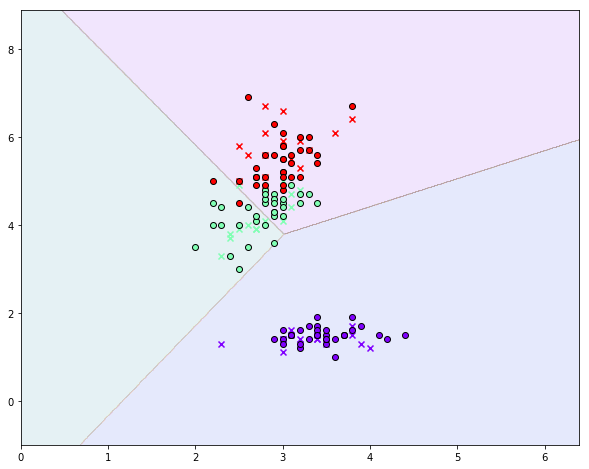

In [9]:
X_all, Y_all = prep_iris_data(df)
n_features = 2
n_classes = 3

# n_features = 2
# n_classes = 3
# X_all, Y_all = generate_random_data(1000, n_features, n_classes)

# training data
train_samples = int( len(X_all) / 3 )
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]

# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

mc = MultiClass(n_features, n_classes)
mc.learn(X_train, Y_train, eta=0.05, epochs=1000)
mc.plot_decision_regions(X, Y, X_train, Y_train, n_classes, 0.01)
plt.show()